### Demand Shape :

In [1]:
import numpy as np
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


#### Constant Demand:

In [2]:
cst_demand = np.ones(365)*20

#### Random Demand :

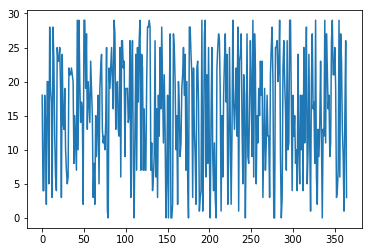

In [3]:
null_orders = np.zeros(365)

plt.plot([np.random.choice(30) for _ in range(365)])

#### Periodic Demand with noise :

In [4]:
data = pd.read_csv('train.csv')
sdata = data[ (data.item == 1) & (data.store == 1) ][['date' , 'sales']]
sdata.date = pd.to_datetime(sdata.date)

STOP = 365
orders = sdata.sales.values[:STOP]

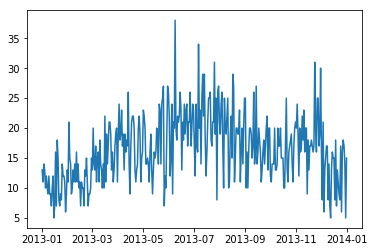

In [5]:
plt.plot(sdata.date[:STOP] , orders)

### Simulator :

In [6]:
from Players import Customer, Retailer, Wholesaler, Distributor, Factory
from SupplyChainActor import SupplyChainQueue
from SupplyChainStatistics import SupplyChainStatistics

In [7]:
VERBOSE = False

In [8]:
constant_customer = Customer(cst_demand , max_noise = 0)
random_customer = Customer(null_orders , max_noise = 30)
periodic_customer = Customer(orders , max_noise = 0)

customer = random_customer

In [10]:
class beer_game_Simulator:
    
    def __init__(self, customer, initial_orders , initial_stock, queue_delay_weeks = 2):
        
        self.theCustomer = customer
        self.weeks_to_play = len(self.theCustomer.orders)
        
        self.queue_delay_weeks = queue_delay_weeks
        self.nstates = 10
        
        self.initial_orders = initial_orders
        self.initial_stock = initial_stock
        
    
    def init_simulation(self , policy_retailer , policy_wholesaler , policy_distributor , policy_factory):

        """
        -------------------------------------------------------
        Given two SupplyChainActors B <--> A, where
        A is higher in the supply chain, let "top queue" denote A's
        outgoingOrderQueue/B's incomingOrderQueue. Let "bottom queue"
        denote B's outgoingDeliveryQueue/A's incoming delivery queue. 
        -------------------------------------------------------
        """
        wholesalerRetailerTopQueue = SupplyChainQueue(self.queue_delay_weeks)
        wholesalerRetailerBottomQueue = SupplyChainQueue(self.queue_delay_weeks)

        distributorWholesalerTopQueue = SupplyChainQueue(self.queue_delay_weeks)
        distributorWholesalerBottomQueue = SupplyChainQueue(self.queue_delay_weeks)

        factoryDistributorTopQueue = SupplyChainQueue(self.queue_delay_weeks)
        factoryDistributorBottomQueue = SupplyChainQueue(self.queue_delay_weeks)
        factoryProductionDelayQueue = SupplyChainQueue(self.queue_delay_weeks)

        """
        -------------------------------------------------------
        Each queue should have at least 2 orders of size CUSTOMER_INITIAL_ORDER 
        -------------------------------------------------------
        """
        for i in range(self.queue_delay_weeks):
            
            wholesalerRetailerTopQueue.PushEnvelope(self.initial_orders)
            wholesalerRetailerBottomQueue.PushEnvelope(self.initial_orders)

            distributorWholesalerTopQueue.PushEnvelope(self.initial_orders)
            distributorWholesalerBottomQueue.PushEnvelope(self.initial_orders)

            factoryDistributorTopQueue.PushEnvelope(self.initial_orders)
            factoryDistributorBottomQueue.PushEnvelope(self.initial_orders)
            #We assume that the factory already has some runs in production. This is in the rules, and ensures initial stability.
            factoryProductionDelayQueue.PushEnvelope(self.initial_orders)


        """
        -------------------------------------------------------
        Now we initialize our SupplyChainObjects. Passing the correct
        queues is essential.
        -------------------------------------------------------
        """


        self.myRetailer = Retailer(policy_retailer ,self.nstates , self.initial_stock,
                                   None, wholesalerRetailerTopQueue, wholesalerRetailerBottomQueue,
                              None, self.theCustomer)

        self.myWholesaler = Wholesaler(policy_wholesaler ,self.nstates , self.initial_stock ,
                                       wholesalerRetailerTopQueue, distributorWholesalerTopQueue,
                                  distributorWholesalerBottomQueue, wholesalerRetailerBottomQueue)

        self.myDistributor = Distributor(policy_distributor ,self.nstates , self.initial_stock ,
                                         distributorWholesalerTopQueue, factoryDistributorTopQueue,
                                    factoryDistributorBottomQueue, distributorWholesalerBottomQueue)

        self.myFactory = Factory(policy_factory ,self.nstates , self.initial_stock,
                                 factoryDistributorTopQueue, None, None, factoryDistributorBottomQueue, 
                            factoryProductionDelayQueue)

        #Initialize Statistics object
        self.myStats = SupplyChainStatistics()
        
        self.weekt = 0
        
        
    def step(self):
        
        res = {'retailer' : {} ,
              'wholesaler' : {} ,
              'distributor' : {} ,
              'factory' : {} }
        
        #Retailer takes turn, update stats
        res['retailer']['state'] , res['retailer']['action'] , res['retailer']['reward'] = self.myRetailer.TakeTurn(self.weekt)

        
        #Wholesaler takes turn, update stats
        res['wholesaler']['state'] , res['wholesaler']['action'] , res['wholesaler']['reward'] = self.myWholesaler.TakeTurn(
                                                                                                                    self.weekt)


        #Distributor takes turn, update stats
        res['distributor']['state'] , res['distributor']['action'] , res['distributor']['reward'] = (self.
                                                                                            myDistributor.TakeTurn(self.weekt))


        #Factory takes turn, update stats
        res['factory']['state'] , res['factory']['action'] , res['factory']['reward'] = self.myFactory.TakeTurn(self.weekt)
        
        self.weekt += 1 
        
        return res
        
        
    
    def run_simulation(self , vis = True):

        for thisWeek in range(0, self.weeks_to_play):

            if VERBOSE: print("--- Week {0} ---".format(thisWeek))

            #Retailer takes turn, update stats
            _ = self.myRetailer.TakeTurn(thisWeek)
            self.myStats.RecordRetailerCost(self.myRetailer.GetCostIncurred())
            self.myStats.RecordRetailerOrders(self.myRetailer.GetLastOrderQuantity())
            self.myStats.RecordRetailerEffectiveInventory(self.myRetailer.CalcEffectiveInventory())
            if VERBOSE: print("Retailer Complete")

            #Wholesaler takes turn, update stats
            _ = self.myWholesaler.TakeTurn(thisWeek)
            self.myStats.RecordWholesalerCost(self.myWholesaler.GetCostIncurred())
            self.myStats.RecordWholesalerOrders(self.myWholesaler.GetLastOrderQuantity())
            self.myStats.RecordWholesalerEffectiveInventory(self.myWholesaler.CalcEffectiveInventory())
            if VERBOSE: print("Wholesaler Complete")

            #Distributor takes turn, update stats
            _ = self.myDistributor.TakeTurn(thisWeek)
            self.myStats.RecordDistributorCost(self.myDistributor.GetCostIncurred())
            self.myStats.RecordDistributorOrders(self.myDistributor.GetLastOrderQuantity())
            self.myStats.RecordDistributorEffectiveInventory(self.myDistributor.CalcEffectiveInventory())
            if VERBOSE: print("Distributor Complete")

            #Factory takes turn, update stats
            _ = self.myFactory.TakeTurn(thisWeek)
            self.myStats.RecordFactoryCost(self.myFactory.GetCostIncurred())
            self.myStats.RecordFactoryOrders(self.myFactory.GetLastOrderQuantity())
            self.myStats.RecordFactoryEffectiveInventory(self.myFactory.CalcEffectiveInventory())
            if VERBOSE: print("Factory Complete")


        if vis:
            print("--- Final Statistics ----")
            print("Beer received by customer: {0}".format(self.theCustomer.GetBeerReceived()))
            self.myStats.PlotCosts()
            self.myStats.PlotOrders()
            self.myStats.PlotEffectiveInventory()

        
        
# todo : add noise + parameter nweeks 
# Step function (taketurns )
    
    
class OrderPolicy:
    
    def __init__(self , target_stock):
        self.target_stock = target_stock
        
    def calculate_order(self, state):
    
        #First weeks are in equilibrium
        

        currentOrders = state[-1][2] + state[-1][3]
        currentStock = state[-1][0] + state[-1][1]
        
        #We want to cover any out flows, we know that there are some orders in the pipeline.
        amountToOrder = np.ceil(0.5 * currentOrders)

        if (self.target_stock - currentStock) > 0:
            amountToOrder += self.target_stock - currentStock

        return amountToOrder , None

We define the state :

* Historic of 5 last stocks
* Current Order 
* Incoming deliveries 
* WeekNumber 

(surveiller si calc cost for turn ne modifie pas certaines choses)
( la fonction doit retourner state , action , reward , newt_state )

In [11]:
#Test with a single step.

#mean_order = int(np.percentile(orders , 95))
mean_order = 30
opolicy = OrderPolicy(mean_order)

Simulator = beer_game_Simulator(customer , mean_order , mean_order)
Simulator.init_simulation(opolicy , opolicy , opolicy , opolicy)
Simulator.step()

{'distributor': {'action': None,
  'reward': -15.0,
  'state': [[-1, -1, -1, -1, -1],
   [-1, -1, -1, -1, -1],
   [-1, -1, -1, -1, -1],
   [-1, -1, -1, -1, -1],
   [-1, -1, -1, -1, -1],
   [-1, -1, -1, -1, -1],
   [-1, -1, -1, -1, -1],
   [-1, -1, -1, -1, -1],
   [-1, -1, -1, -1, -1],
   [30, 30, 0, 30, 30]]},
 'factory': {'action': None,
  'reward': -15.0,
  'state': [[-1, -1, -1, -1, -1],
   [-1, -1, -1, -1, -1],
   [-1, -1, -1, -1, -1],
   [-1, -1, -1, -1, -1],
   [-1, -1, -1, -1, -1],
   [-1, -1, -1, -1, -1],
   [-1, -1, -1, -1, -1],
   [-1, -1, -1, -1, -1],
   [-1, -1, -1, -1, -1],
   [30, 30, 0, 30, 30]]},
 'retailer': {'action': None,
  'reward': -26.5,
  'state': [[-1, -1, -1, -1, -1],
   [-1, -1, -1, -1, -1],
   [-1, -1, -1, -1, -1],
   [-1, -1, -1, -1, -1],
   [-1, -1, -1, -1, -1],
   [-1, -1, -1, -1, -1],
   [-1, -1, -1, -1, -1],
   [-1, -1, -1, -1, -1],
   [-1, -1, -1, -1, -1],
   [30, 30, 0, 7.0, 30]]},
 'wholesaler': {'action': None,
  'reward': -15.0,
  'state': [[-1, -1

--- Final Statistics ----
Beer received by customer: 31892.0


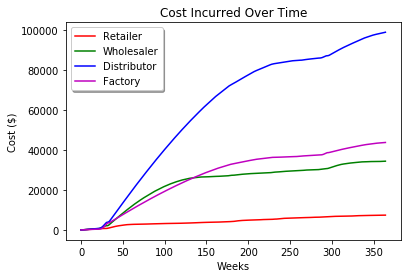

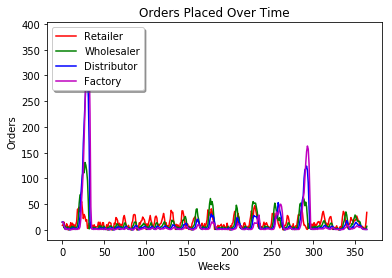

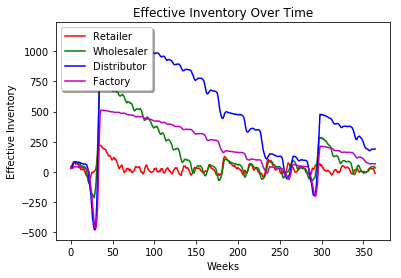

In [17]:
#mean_order = int(np.percentile(orders , 95))
mean_order = 30
opolicy = OrderPolicy(mean_order)

Simulator = beer_game_Simulator(customer , mean_order , mean_order)
Simulator.init_simulation(opolicy , opolicy , opolicy , opolicy)

Simulator.run_simulation()

### Reinforcement Learning :

#### Replay Memory :

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from collections import namedtuple
import random

device = "cpu"# torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

-  ``Transition`` - a named tuple representing a single transition in
   our environment
-  ``ReplayMemory`` - a cyclic buffer of bounded size that holds the
   transitions observed recently. It also implements a ``.sample()``
   method for selecting a random batch of transitions for training.

In [20]:
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

#### DQN :

**Formulas** :

The main idea behind Q-learning is that if we had a function
$Q^*: State \times Action \rightarrow \mathbb{R}$, that could tell
us what our return would be, if we were to take an action in a given
state, then we could easily construct a policy that maximizes our
rewards:

\begin{align}\pi^*(s) = \arg\!\max_a \ Q^*(s, a)\end{align}

For our training update rule, we'll use a fact that every $Q$
function for some policy obeys the Bellman equation:

\begin{align}Q^{\pi}(s, a) = r + \gamma Q^{\pi}(s', \pi(s'))\end{align}

The difference between the two sides of the equality is known as the
temporal difference error, $\delta$:

\begin{align}\delta = Q(s, a) - (r + \gamma \max_a Q(s', a))\end{align}

To minimise this error, we will use the `Huber loss <https://en.wikipedia.org/wiki/Huber_loss>`

**State Variables** : current stock for the moment t and the previous ones, current incoming orders

**Actions** : Number of units to order : 2*max(orders) 

In [21]:
MAX_ACTIONS = 30

EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 36500/2

class DQN(nn.Module):

    def __init__(self):
        super(DQN, self).__init__()
        
        self.fc1 = nn.Linear(50, 100)
        self.fc2 = nn.Linear(100 , 100)
        self.fc4 = nn.Linear(100, MAX_ACTIONS)

    def forward(self, x):
        output = x.view(x.shape[0],-1 )
        output = F.relu(self.fc1(output))
        output = F.relu(self.fc2(output))
        output = self.fc4(output)
        return output
    

########################
class DQN_Policy:
    
    def __init__(self , network , train = False):
        self.network = network
        self.train = train
        
    def calculate_order(self, array):
        
        if self.train:
            # Exploration :
            pb_exploration = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * N_STEPS / EPS_DECAY)
            if np.random.random() <= pb_exploration:
                action = int(np.random.choice(MAX_ACTIONS))
                return array[-1][1] + action - int(MAX_ACTIONS/2) , action
            
        
        x = torch.tensor([array] , dtype = torch.float32)
        q_values = self.network(x)
        action = int(torch.argmax(q_values))

        return array[-1][1] + action - int(MAX_ACTIONS/2) , action

36500


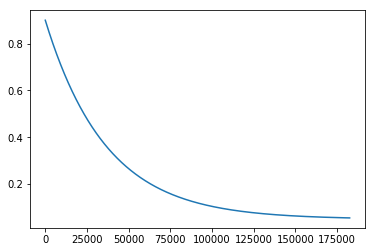

In [22]:
n_orders = len(orders)
nepisodes = 500

decay = n_orders*100
print(decay)

evolution = [EPS_END + (EPS_START - EPS_END) * np.exp(-1. * n / decay) for n in range(nepisodes * n_orders) ]
plt.plot(evolution)
plt.show()

In [23]:
def optimize_model(policy_net, target_net , optimizer , memory):
    
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch 
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.uint8)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken
    state_action_values = policy_net(state_batch).gather(1, action_batch.long())

    # Compute V(s_{t+1}) for all next states.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [24]:
MAX_REWARD = -1000

def initialize_training():
    new_policy = DQN_Policy( DQN() .to(device) )
    target_net = DQN().to(device)
    target_net.load_state_dict(new_policy.network.state_dict())
    new_memory = ReplayMemory(MEMORY)
    
    return new_policy , target_net , new_memory

def transition_variables(ob, key):
    return ob[key]['state'] , ob[key]['action'] , max(ob[key]['reward'] , MAX_REWARD)

def to_tensors(variables):
    
    # format : state , action , reward , new_state
    tensors = [ torch.tensor([v], device=device , dtype = torch.float32) for v in variables ]
    tensors[1] = tensors[1].view(1 , 1) # We adapt the action tensor shape.
    
    return tensors


#######

def update_costs(Simulator , policies , cost_lists , n_sims = 1):
    
    # Turn off the training:
    for pol in policies:
        if hasattr(pol , 'train'): pol.train = False
        
    # Run Simulations:
    retailer_cost , wholesaler_cost , distributor_cost , factory_cost = 0 , 0 , 0 , 0
    for _ in range(n_sims):
        
        Simulator.init_simulation(*policies)
        Simulator.run_simulation(vis = False)
        
        retailer_cost += Simulator.myRetailer.GetCostIncurred()
        wholesaler_cost += Simulator.myWholesaler.GetCostIncurred()
        distributor_cost += Simulator.myDistributor.GetCostIncurred()
        factory_cost += Simulator.myFactory.GetCostIncurred()
        
    cvars = [retailer_cost , wholesaler_cost , distributor_cost , factory_cost]
    
    for l,v in zip(cost_lists ,cvars):
        l.append(v/n_sims)
        
    for pol in policies:
        if hasattr(pol , 'train'): pol.train = True

### Single Agent Training :

In [30]:
################################################

num_episodes = 400

# Simulator Initialisation
Simulator = beer_game_Simulator(customer , mean_order , mean_order)


# Main Loop :
BATCH_SIZE = 32
GAMMA = 1
TARGET_UPDATE = 10
MEMORY = 10000


# Retailer Policy
retailer_policy ,target_retailer_net , retailer_memory = initialize_training()
retailer_optimizer = optim.RMSprop(retailer_policy.network.parameters() , lr = 0.001 , centered = True)
exp_lr_scheduler = optim.lr_scheduler.StepLR(retailer_optimizer, step_size=365*100, gamma=0.5)


N_STEPS = 0

retailer_policy.train , retailer_costs = True , []
wholesaler_costs = []
distributor_costs = []
factory_costs = []


for i_episode in range(num_episodes):
    
    # Initialize the environment and state
    Simulator.init_simulation(retailer_policy , opolicy , opolicy , opolicy)
    
    # First step of the Simulator 
    step_returns = Simulator.step() # State , action , reward of each player
    
    # We take the variabls of interest 
    retailer_variables = transition_variables(step_returns , 'retailer')
    
    print('EPISODE : ' + str(i_episode))
    
    
    for t in range(len(orders) - 1):
        # Select and perform an action
        
        step_returns = Simulator.step() # new Simulator Step
        
        next_retailer_variables = transition_variables(step_returns , 'retailer') #Variables of the new step
        
        # We add the new observed state to the previous incomplete transition.
        retailer_transition = to_tensors(retailer_variables + (next_retailer_variables[0] ,) )

        # Store the transition in memory
        retailer_memory.push(*retailer_transition)
        
        # Update the current state variables
        retailer_variables = next_retailer_variables

        # Perform one step of the optimization (on the policies network)
        optimize_model(retailer_policy.network , target_retailer_net , retailer_optimizer , retailer_memory)
        
        
        N_STEPS += 1 # New step.

    # Update the target network
    if i_episode % TARGET_UPDATE == 0:
        target_retailer_net.load_state_dict(retailer_policy.network.state_dict())

        
    # Cost_plot:
    update_costs(Simulator , [retailer_policy , opolicy , opolicy , opolicy] 
                 , cost_lists = [retailer_costs ,wholesaler_costs ,distributor_costs , factory_costs])
        
        
retailer_policy.train = False
print('Complete')

EPISODE : 0
EPISODE : 1
EPISODE : 2
EPISODE : 3
EPISODE : 4
EPISODE : 5
EPISODE : 6
EPISODE : 7
EPISODE : 8
EPISODE : 9
EPISODE : 10
EPISODE : 11
EPISODE : 12
EPISODE : 13
EPISODE : 14
EPISODE : 15
EPISODE : 16
EPISODE : 17
EPISODE : 18
EPISODE : 19
EPISODE : 20
EPISODE : 21
EPISODE : 22
EPISODE : 23
EPISODE : 24
EPISODE : 25
EPISODE : 26
EPISODE : 27
EPISODE : 28
EPISODE : 29
EPISODE : 30
EPISODE : 31
EPISODE : 32
EPISODE : 33
EPISODE : 34
EPISODE : 35
EPISODE : 36
EPISODE : 37
EPISODE : 38
EPISODE : 39
EPISODE : 40
EPISODE : 41
EPISODE : 42
EPISODE : 43
EPISODE : 44
EPISODE : 45
EPISODE : 46
EPISODE : 47
EPISODE : 48
EPISODE : 49
EPISODE : 50
EPISODE : 51
EPISODE : 52
EPISODE : 53
EPISODE : 54
EPISODE : 55
EPISODE : 56
EPISODE : 57
EPISODE : 58
EPISODE : 59
EPISODE : 60
EPISODE : 61
EPISODE : 62
EPISODE : 63
EPISODE : 64
EPISODE : 65
EPISODE : 66
EPISODE : 67
EPISODE : 68
EPISODE : 69
EPISODE : 70
EPISODE : 71
EPISODE : 72
EPISODE : 73
EPISODE : 74
EPISODE : 75
EPISODE : 76
EPISODE :

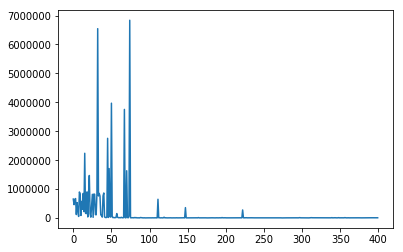

In [31]:
plt.plot(retailer_costs)

In [60]:
# data = [go.Scatter(
#           x=np.arange(len(retailer_costs)),
#           y=retailer_costs)]

# # Plot and embed in ipython notebook!
# iplot(data)

--- Final Statistics ----
Beer received by customer: 8375852.0


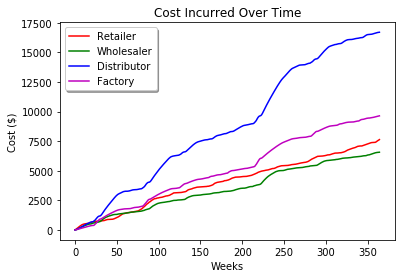

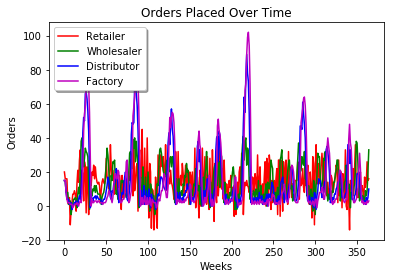

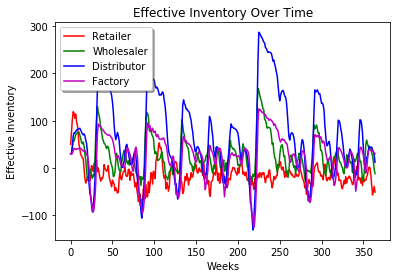

In [38]:
Simulator.init_simulation(retailer_policy , opolicy , opolicy , opolicy)
Simulator.run_simulation()

### Two Agents training :

In [28]:
################################################
num_episodes = 400

# Simulator Initialisation
Simulator = beer_game_Simulator(orders)


# Main Loop :
BATCH_SIZE = 32
GAMMA = 1
TARGET_UPDATE = 10
MEMORY = 10000


# Retailer Policy :
retailer_policy ,target_retailer_net , retailer_memory = initialize_training()
retailer_optimizer = optim.RMSprop(retailer_policy.network.parameters() , lr = 0.001)

#Wholesaler Policy :
wholesaler_policy ,target_wholesaler_net , wholesaler_memory = initialize_training()
wholesaler_optimizer = optim.RMSprop(wholesaler_policy.network.parameters() , lr = 0.001)
LAG_WHOLESALER = 0

N_STEPS = 0

retailer_policy.train , retailer_costs = True , []
wholesaler_policy.train , wholesaler_costs = True , []
distributor_costs = []
factory_costs = []


for i_episode in range(num_episodes):
    
    # Initialize the environment and state
    Simulator.init_simulation(retailer_policy , wholesaler_policy , opolicy , opolicy)
    
    # First step of the Simulator 
    step_returns = Simulator.step()
    
    # We take the variabls of interest 
    retailer_variables = transition_variables(step_returns , 'retailer')
    wholesaler_variables = transition_variables(step_returns , 'wholesaler')
    
    print('EPISODE : ' + str(i_episode))
    
    
    for t in range(len(orders) - 1):
        # Select and perform an action

        step_returns = Simulator.step() # new Simulator Step
        
        next_retailer_variables = transition_variables(step_returns , 'retailer') #Variables of the new step
        next_wholesaler_variables = transition_variables(step_returns , 'wholesaler')
        
        # We add the new observed state to the previous incomplete transition.
        retailer_transition = to_tensors(retailer_variables + (next_retailer_variables[0] ,) )
        wholesaler_transition = to_tensors(wholesaler_variables + (next_wholesaler_variables[0] ,) )

        # Store the transition in memory
        retailer_memory.push(*retailer_transition)
        wholesaler_memory.push(*wholesaler_transition)
        
        # Update the current state variables
        retailer_variables = next_retailer_variables
        wholesaler_variables = next_wholesaler_variables

        # Perform one step of the optimization (on the policies network)
        optimize_model(retailer_policy.network , target_retailer_net , retailer_optimizer , retailer_memory)
        optimize_model(wholesaler_policy.network , target_wholesaler_net , wholesaler_optimizer , wholesaler_memory)
        
        
        N_STEPS += 1 # New step.

    # Update the target network
    if i_episode % TARGET_UPDATE == 0:
        target_retailer_net.load_state_dict(retailer_policy.network.state_dict())
        target_wholesaler_net.load_state_dict(wholesaler_policy.network.state_dict())

        
    # Cost_plot:
    update_costs(Simulator , [retailer_policy , wholesaler_policy , opolicy , opolicy] 
                 , cost_lists = [retailer_costs ,wholesaler_costs ,distributor_costs , factory_costs])
        
        
retailer_policy.train = False
print('Complete')

EPISODE : 0
EPISODE : 1
EPISODE : 2
EPISODE : 3
EPISODE : 4
EPISODE : 5
EPISODE : 6
EPISODE : 7
EPISODE : 8
EPISODE : 9
EPISODE : 10
EPISODE : 11
EPISODE : 12
EPISODE : 13
EPISODE : 14
EPISODE : 15
EPISODE : 16
EPISODE : 17
EPISODE : 18
EPISODE : 19
EPISODE : 20
EPISODE : 21
EPISODE : 22
EPISODE : 23
EPISODE : 24
EPISODE : 25
EPISODE : 26
EPISODE : 27
EPISODE : 28
EPISODE : 29
EPISODE : 30
EPISODE : 31
EPISODE : 32
EPISODE : 33
EPISODE : 34
EPISODE : 35
EPISODE : 36
EPISODE : 37
EPISODE : 38
EPISODE : 39
EPISODE : 40
EPISODE : 41
EPISODE : 42
EPISODE : 43
EPISODE : 44
EPISODE : 45
EPISODE : 46
EPISODE : 47
EPISODE : 48
EPISODE : 49
EPISODE : 50
EPISODE : 51
EPISODE : 52
EPISODE : 53
EPISODE : 54
EPISODE : 55
EPISODE : 56
EPISODE : 57
EPISODE : 58
EPISODE : 59
EPISODE : 60
EPISODE : 61
EPISODE : 62
EPISODE : 63
EPISODE : 64
EPISODE : 65
EPISODE : 66
EPISODE : 67
EPISODE : 68
EPISODE : 69
EPISODE : 70
EPISODE : 71
EPISODE : 72
EPISODE : 73
EPISODE : 74
EPISODE : 75
EPISODE : 76
EPISODE :

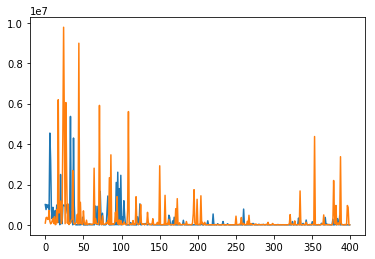

--- Final Statistics ----
Beer received by customer: 6017.0


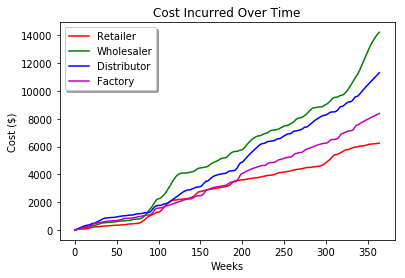

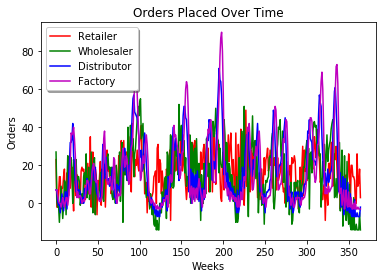

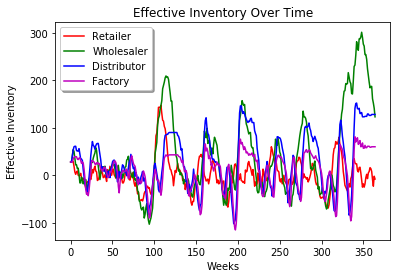

In [29]:
plt.plot(retailer_costs)
plt.plot(wholesaler_costs)
plt.show()

Simulator.init_simulation(retailer_policy , wholesaler_policy , opolicy , opolicy)
Simulator.run_simulation()